# Predicting neural activity

The objectives of the project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

This project is part of the course NX-414: Brain-like Intelligence.

In [1]:
import sys
!{sys.executable} -m pip -q install gdown h5py

from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown
import os
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns

from scipy.stats import ttest_rel


url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
if not os.path.exists("IT_data.h5"):
    gdown.download(url, output, quiet=False, fuzzy=True)

In [11]:
from brainscore_vision.models.timm_models import get_model as get_timm_model
from brainscore_vision.models.timm_models.models import MODEL_CONFIGS

ModuleNotFoundError: No module named 'brainscore_vision.models.timm_models.models'

In [ ]:
!git clone https://github.com/brain-score/vision.git
!cd vision
!pip install -e .

In [6]:
pip install git+https://github.com/brain-score/vision.git

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.comNote: you may need to restart the kernel to use updated packages.

  Cloning https://github.com/brain-score/vision.git to c:\users\charl\appdata\local\temp\pip-req-build-qk89blvr
  Resolved https://github.com/brain-score/vision.git to commit ec3df4cd9563a1d068e4ed5d971f1fbdda208b76
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for brainscore_vision: filename=brainscore_vision-2.2.11-py3-none-any.whl size=29747789 sha256=cb69779ad891901ecf9db9099975906bc5d858921c69dcf11c42d0147dcc1894
  Stored in directory: C:\Users\charl\AppData\Local\Temp\pip-ephem-wheel-cache-eimuofya\wheels\8b\88\7f\e33e51819d0cd36104751db160c83526ce3

  Running command git clone --filter=blob:none --quiet https://github.com/brain-score/vision.git 'C:\Users\charl\AppData\Local\Temp\pip-req-build-qk89blvr'

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Load the data

In [2]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

# stim: picture / object: object name + idx / spikes: rate of each spike per stim

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

In [3]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The train dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The train dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


In [4]:
# counts of each object in the object list

object_counts = {}
for obj in objects_train:
    if obj in object_counts:
        object_counts[obj] += 1
    else:
        object_counts[obj] = 1

sorted_objects = sorted(object_counts.items(), key=lambda x: x[1], reverse=True)
print("Object counts:")
for obj, count in sorted_objects:
    print(f"{obj}: {count}")

Object counts:
face6: 41
table3: 41
face3: 41
lioness: 41
turtle: 41
airplane3: 41
table2: 41
airplane0: 41
airplane6: 41
face0: 41
table5: 41
table1: 41
airplane5: 41
table7: 41
chair0: 41
car_beetle: 41
airplane4: 41
car_clio: 41
apple: 41
face1: 41
ship6: 41
car_celica: 41
apricot: 41
face4: 41
car_astra: 41
ship3: 41
table6: 41
ship0: 41
chair6: 41
ship5: 41
peach: 41
strawberry: 41
face2: 40
cow: 40
car_alfa: 40
ship1: 40
car_bora: 40
chair4: 40
chair2: 40
gorilla: 40
raspberry: 40
pear: 40
chair5: 40
airplane2: 40
chair7: 40
face7: 40
ship7: 40
table0: 40
car_z3: 40
walnut: 40
chair3: 40
elephant: 40
table4: 40
ship2: 40
watermelon: 40
dog: 40
airplane7: 40
car_bmw: 40
hedgehog: 40
bear: 40
airplane1: 40
ship4: 40
face5: 40
chair1: 40


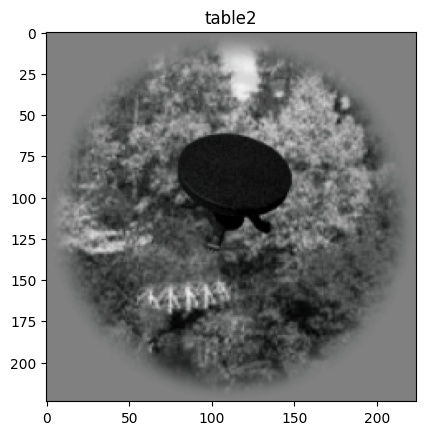

In [5]:
stim_idx = 10

visualize_img(stimulus_train,objects_train,stim_idx)

In [6]:
print(stim_idx)
print(stimulus_train[stim_idx].shape)
print(objects_train[stim_idx])

10
(3, 224, 224)
table2


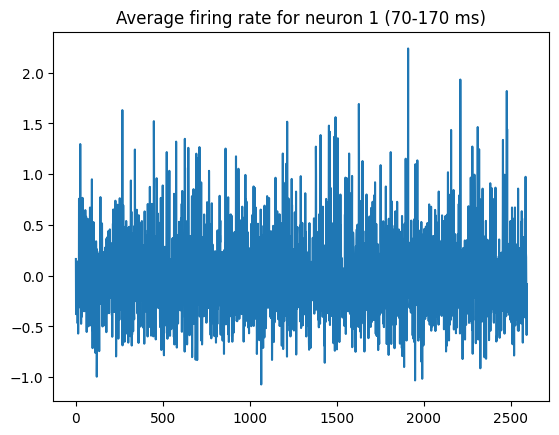

In [7]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

In [8]:
variables = [stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val]
variables_names = ['stimulus_train', 'stimulus_val', 'stimulus_test', 'objects_train', 'objects_val', 'objects_test', 'spikes_train', 'spikes_val']

for i in range(len(variables)):
    if isinstance(variables[i], np.ndarray):
        print('{}: {}'.format(variables_names[i], variables[i].shape))
    else:
        print('{}: {}'.format(variables_names[i], len(variables[i])))


stimulus_train: (2592, 3, 224, 224)
stimulus_val: (288, 3, 224, 224)
stimulus_test: (320, 3, 224, 224)
objects_train: 2592
objects_val: 288
objects_test: 320
spikes_train: (2592, 168)
spikes_val: (288, 168)


## Part 1: Predict the neural activity from pixels

##### Develop a linear regression model that predict the neural activity from pixels.
You can try out different types of linear regression (ridge, least-square regression)

- use each pixel channel as a different input?
- don't use any of test vars?
- is normalization of pixel values needed before fitting the model for coef interpretability (as there is a circular filter in images, so pixel vals are not random)

In [9]:
#### Here your code
print("Initial shape of the data")
print(stimulus_train.shape)
print(stimulus_val.shape)

X_train = stimulus_train.reshape(stimulus_train.shape[0],-1)
X_val = stimulus_val.reshape(stimulus_val.shape[0],-1)

print("Shape of the data after reshaping")
print(X_train.shape)
print(X_val.shape)

y_train = spikes_train
y_val = spikes_val

Initial shape of the data
(2592, 3, 224, 224)
(288, 3, 224, 224)
Shape of the data after reshaping
(2592, 150528)
(288, 150528)


In [10]:
# linear regression
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print("Linear regression without normalization")
print("MSE: ", mean_squared_error(y_val, y_pred))

# ridge regression
ridge_model = Ridge(alpha=1.0, solver="auto") # the matrix is said to be ill-conditioned but we did not observe any significant difference in the results
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_val)
print("Ridge regression without normalization")
print("MSE: ", mean_squared_error(y_val, y_pred_ridge))

Linear regression without normalization
MSE:  0.1429024189710617


/opt/common/envs/blc/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:252: LinAlgWarning: Ill-conditioned matrix (rcond=5.20358e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Ridge regression without normalization
MSE:  0.28518688678741455


We are doing the same naive model for linreg and ridge but with normalization this time

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# linear regression with normalization
model_scaled = LinearRegression()
model_scaled.fit(X_train_scaled, y_train)
y_pred_scaled = model_scaled.predict(X_val_scaled)
print("Linear regression with normalization")
print("MSE: ", mean_squared_error(y_val, y_pred_scaled))

# ridge regression with normalization
ridge_model_scaled = Ridge(alpha=1.0, solver="auto") # the matrix is said to be ill-conditioned but we did not observe any significant difference in the results
ridge_model_scaled.fit(X_train_scaled, y_train)
y_pred_ridge_scaled = ridge_model_scaled.predict(X_val_scaled)
print("Ridge regression with normalization")
print("MSE: ", mean_squared_error(y_val, y_pred_ridge_scaled))

Linear regression with normalization
MSE:  0.14295127987861633


/opt/common/envs/blc/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:252: LinAlgWarning: Ill-conditioned matrix (rcond=5.98183e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Ridge regression with normalization
MSE:  0.25174883008003235


##### Evaluate your prediction (Check both the correlation and explained variance for each neuron). Plot the distribution for the explained variance across neurons.

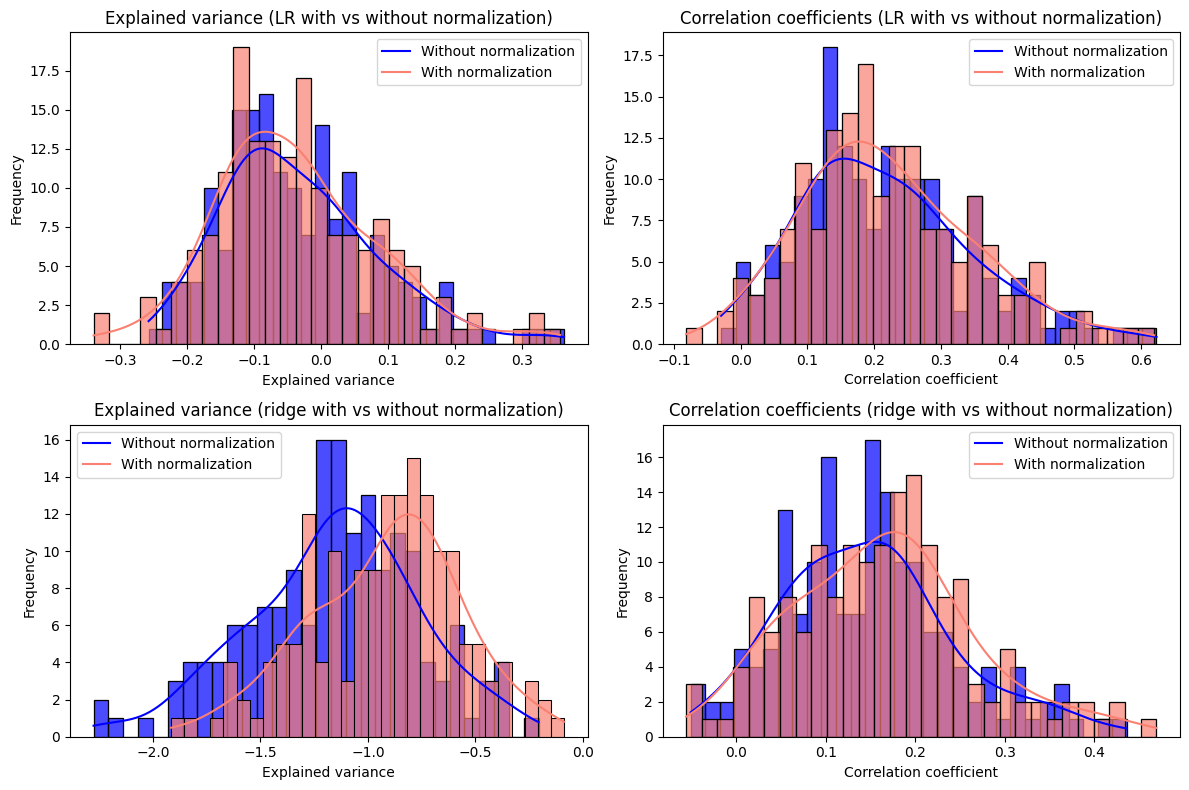

In [12]:
### For linear regression without normalization
# Explained variance (per neuron)
explained_variance = explained_variance_score(spikes_val, y_pred, multioutput='raw_values')
# Pearson correlation (per neuron)
correlation = np.array([
    np.corrcoef(spikes_val[:, i], y_pred[:, i])[0, 1]
    for i in range(spikes_val.shape[1])
])

### For linear regression with normalization
explained_variance_scaled = explained_variance_score(spikes_val, y_pred_scaled, multioutput='raw_values')
correlation_scaled = np.array([
    np.corrcoef(spikes_val[:, i], y_pred_scaled[:, i])[0, 1]
    for i in range(spikes_val.shape[1])
])

### For ridge regression without normalization
explained_variance_ridge = explained_variance_score(spikes_val, y_pred_ridge, multioutput='raw_values')
correlation_ridge = np.array([
    np.corrcoef(spikes_val[:, i], y_pred_ridge[:, i])[0, 1]
    for i in range(spikes_val.shape[1])
])

### For ridge regression with normalization
explained_variance_ridge_scaled = explained_variance_score(spikes_val, y_pred_ridge_scaled, multioutput='raw_values')
correlation_ridge_scaled = np.array([
    np.corrcoef(spikes_val[:, i], y_pred_ridge_scaled[:, i])[0, 1]
    for i in range(spikes_val.shape[1])
])

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# First plot: Explained variance (Linear Regression)
axs[0, 0].set_title('Explained variance (LR with vs without normalization)')
sns.histplot(explained_variance, bins=30, kde=True, color='blue', alpha=0.7, ax=axs[0, 0])
sns.histplot(explained_variance_scaled, bins=30, kde=True, color='salmon', alpha=0.7, ax=axs[0, 0])
axs[0, 0].set_xlabel('Explained variance')
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].legend(['Without normalization', 'With normalization'])

# Second plot: Correlation coefficients (Linear Regression)
axs[0, 1].set_title('Correlation coefficients (LR with vs without normalization)')
sns.histplot(correlation, bins=30, kde=True, color='blue', alpha=0.7, ax=axs[0, 1])
sns.histplot(correlation_scaled, bins=30, kde=True, color='salmon', alpha=0.7, ax=axs[0, 1])
axs[0, 1].set_xlabel('Correlation coefficient')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].legend(['Without normalization', 'With normalization'])

# Third plot: Explained variance (Ridge Regression)
axs[1, 0].set_title('Explained variance (ridge with vs without normalization)')
sns.histplot(explained_variance_ridge, bins=30, kde=True, color='blue', alpha=0.7, ax=axs[1, 0])
sns.histplot(explained_variance_ridge_scaled, bins=30, kde=True, color='salmon', alpha=0.7, ax=axs[1, 0])
axs[1, 0].set_xlabel('Explained variance')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].legend(['Without normalization', 'With normalization'])

# Fourth plot: Correlation coefficients (Ridge Regression)
axs[1, 1].set_title('Correlation coefficients (ridge with vs without normalization)')
sns.histplot(correlation_ridge, bins=30, kde=True, color='blue', alpha=0.7, ax=axs[1, 1])
sns.histplot(correlation_ridge_scaled, bins=30, kde=True, color='salmon', alpha=0.7, ax=axs[1, 1])
axs[1, 1].set_xlabel('Correlation coefficient')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].legend(['Without normalization', 'With normalization'])

plt.tight_layout()
plt.show()


##### Predicting from pixels is very hard and the model is likely to overfit. An image is very high-dimensional, try to retain the corresponding 1000 PCs and use them to predict the neural activity. 

Again, naive models but this time with both normalization and PCA on 1000 features.

In [13]:
#### Here your code
n_comps = 1000
pca_train = PCA(n_components=n_comps).fit(X_train_scaled)

X_train_pca = pca_train.transform(X_train_scaled)
X_val_pca = pca_train.transform(X_val_scaled)

print("Shape of the data after PCA")
print(X_train_pca.shape)
print(X_val_pca.shape)

model = LinearRegression().fit(X_train_pca,y_train)
y_pred_pca = model.predict(X_val_pca)
print("Linear regression with PCA")
print("MSE: ", mean_squared_error(y_val, y_pred_pca))

ridge_model = Ridge(alpha=1.0).fit(X_train_pca,y_train)
y_pred_ridge_pca = ridge_model.predict(X_val_pca)
print("Ridge regression with PCA")
print("MSE: ", mean_squared_error(y_val, y_pred_ridge_pca))

Shape of the data after PCA
(2592, 1000)
(288, 1000)
Linear regression with PCA
MSE:  0.14744211733341217
Ridge regression with PCA
MSE:  0.14744052290916443


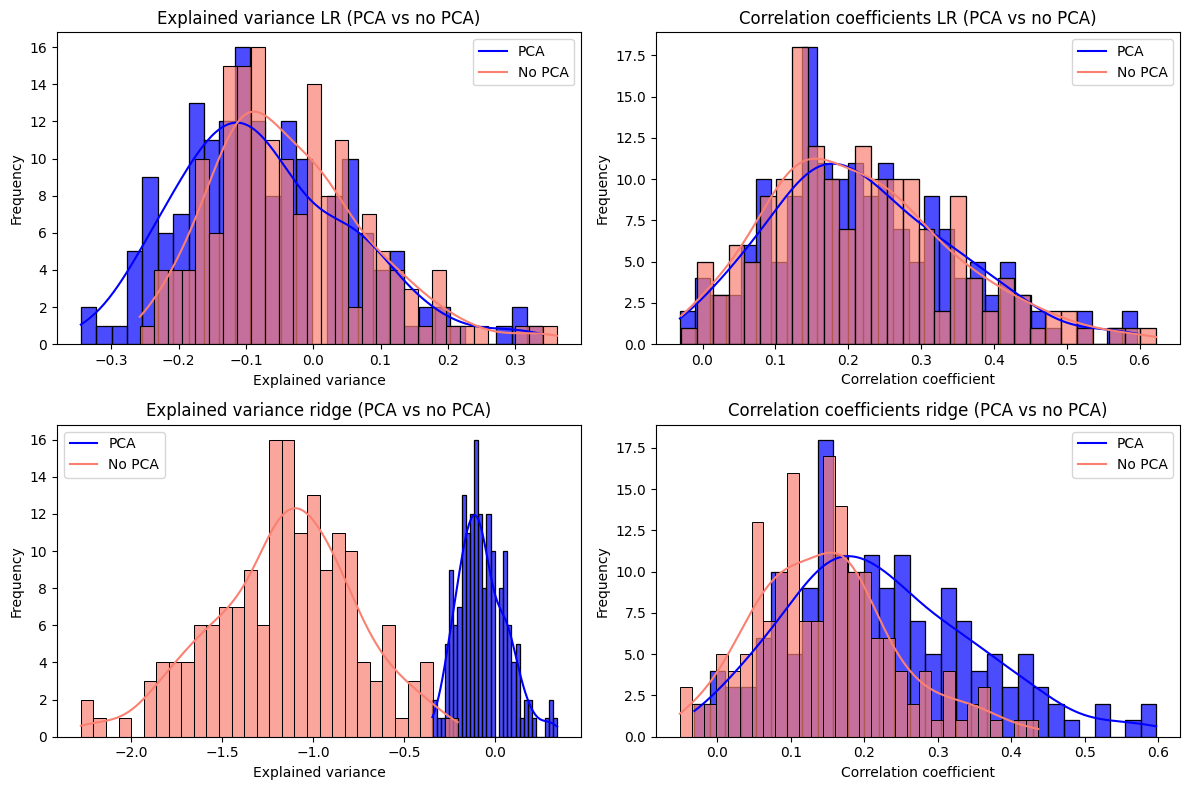

In [14]:
# Explained variance (per neuron)
explained_variance_pca = explained_variance_score(spikes_val, y_pred_pca, multioutput='raw_values')
explained_variance_ridge_pca = explained_variance_score(spikes_val, y_pred_ridge_pca, multioutput='raw_values')

# Pearson correlation (per neuron) for PCA
correlation_pca = np.array([
    np.corrcoef(spikes_val[:, i], y_pred_pca[:, i])[0, 1]
    for i in range(spikes_val.shape[1])
])
correlation_ridge_pca = np.array([
    np.corrcoef(spikes_val[:, i], y_pred_ridge_pca[:, i])[0, 1]
    for i in range(spikes_val.shape[1])
])

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# First plot: Explained variance LR (PCA vs no PCA)
axs[0, 0].set_title('Explained variance LR (PCA vs no PCA)', fontsize=12)
sns.histplot(explained_variance_pca, bins=30, kde=True, color='blue', alpha=0.7, ax=axs[0, 0])
sns.histplot(explained_variance, bins=30, kde=True, color='salmon', alpha=0.7, ax=axs[0, 0])
axs[0, 0].set_xlabel('Explained variance')
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].legend(['PCA', 'No PCA'])

# Second plot: Correlation coefficients (PCA LR vs Ridge)
axs[0, 1].set_title('Correlation coefficients LR (PCA vs no PCA)', fontsize=12)
sns.histplot(correlation_pca, bins=30, kde=True, color='blue', alpha=0.7, ax=axs[0, 1])
sns.histplot(correlation, bins=30, kde=True, color='salmon', alpha=0.7, ax=axs[0, 1])
axs[0, 1].set_xlabel('Correlation coefficient')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].legend(['PCA', 'No PCA'])

# Third plot: Explained variance Ridge (PCA vs Ridge w/o PCA)
axs[1, 0].set_title('Explained variance ridge (PCA vs no PCA)', fontsize=12)
sns.histplot(explained_variance_ridge_pca, bins=30, kde=True, color='blue', alpha=0.7, ax=axs[1, 0])
sns.histplot(explained_variance_ridge, bins=30, kde=True, color='salmon', alpha=0.7, ax=axs[1, 0])
axs[1, 0].set_xlabel('Explained variance')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].legend(['PCA', 'No PCA'])

# Fourth plot: Correlation coefficients (PCA Ridge vs Ridge)
axs[1, 1].set_title('Correlation coefficients ridge (PCA vs no PCA)', fontsize=12)
sns.histplot(correlation_ridge_pca, bins=30, kde=True, color='blue', alpha=0.7, ax=axs[1, 1])
sns.histplot(correlation_ridge, bins=30, kde=True, color='salmon', alpha=0.7, ax=axs[1, 1])
axs[1, 1].set_xlabel('Correlation coefficient')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].legend(['PCA', 'No PCA'])

plt.tight_layout()
plt.show()


##### Can we improve the prediction? Using the ridge regression, find the best parameter with cross-fold validation (remember to split the data keeping the same distribution of classes between the train and validation set). Does it get better?

Can use stratified-kfold for object balancing across train and validation

In [15]:
# silence warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# memory variable for the pipeline
from joblib import Memory
memory = Memory("./cachedir", verbose=0)

#### Linear Regression, grid search on PCA components with stratified kfold

In [16]:
# we want to add normalisation only on the training set and it changes for each fold, hence pipeline
# also, we saw that matrices well ill-conditioned, hence we add PCA to experiment with reducing the colinearity
# solver='svd' also for ill-conditioned matrices
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    # ('ridge', Ridge(solver='svd'))
    ('linreg', LinearRegression())
], memory=memory)

param_grid = {
    # 'ridge__alpha': np.logspace(-2, 2, 5),
    'pca__n_components': [0.8, 0.9, 0.95],
}
cv = KFold(n_splits=2, shuffle=True, random_state=42)

# dont set n_jobs=-1, it will memory leak and freeze the pc
linreg_grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=cv.split(X_train, y_train, objects_train),
    n_jobs=4
)

linreg_grid_search.fit(X_train, y_train)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f3489272320>,
             estimator=Pipeline(memory=Memory(location=./cachedir/joblib),
                                steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('linreg', LinearRegression())]),
             n_jobs=4, param_grid={'pca__n_components': [0.8, 0.9, 0.95]},
             scoring='neg_mean_squared_error')

In [17]:
print("Scores for each PCA component:")
for i, score in enumerate(linreg_grid_search.cv_results_['mean_test_score']):
    print(f"Component {i+1}: {score:.4f}")

Scores for each PCA component:
Component 1: -0.1284
Component 2: -0.1349
Component 3: -0.1441


Best model performance:
Explained variance:  0.08134555
Correlation coefficients:  0.26763915873026195
MSE:  0.1276068240404129


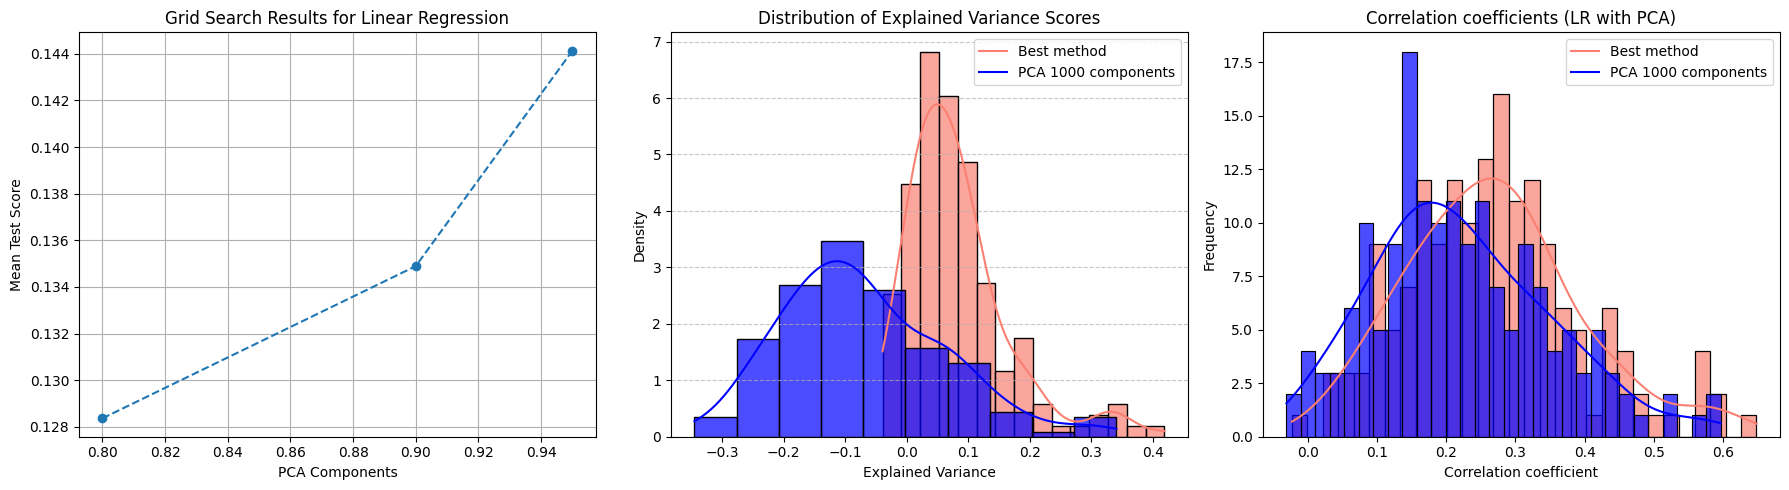

In [18]:
linreg_grid_search_df = pd.DataFrame(linreg_grid_search.cv_results_)

pipeline.set_params(**linreg_grid_search.best_params_)
pipeline.fit(X_train, y_train)

y_pred_pipeline = pipeline.predict(X_val)
explained_variance_pipeline = explained_variance_score(y_val, y_pred_pipeline, multioutput='raw_values')

correlation_pipeline = np.array([
    np.corrcoef(y_val[:, i], y_pred_pipeline[:, i])[0, 1]
    for i in range(y_val.shape[1])
])

print("Best model performance:")
print("Explained variance: ", explained_variance_pipeline.mean())
print("Correlation coefficients: ", correlation_pipeline.mean())
print("MSE: ", mean_squared_error(y_val, y_pred_pipeline))

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Grid Search Results
axs[0].plot(
    linreg_grid_search_df['param_pca__n_components'],
    (-1) * linreg_grid_search_df['mean_test_score'],
    marker='o',
    linestyle='--'
)
axs[0].set_xlabel('PCA Components')
axs[0].set_ylabel('Mean Test Score')
axs[0].set_title('Grid Search Results for Linear Regression')
axs[0].grid()

# Plot 2: Explained Variance Distributions
sns.histplot(explained_variance_pipeline, kde=True, stat='density', color='salmon', alpha=0.7, ax=axs[1])
sns.histplot(explained_variance_pca, kde=True, stat='density', color='blue', alpha=0.7, ax=axs[1])
axs[1].set_title("Distribution of Explained Variance Scores", fontsize=12)
axs[1].set_xlabel("Explained Variance")
axs[1].set_ylabel("Density")
axs[1].grid(axis='y', linestyle='--', alpha=0.7)
axs[1].legend(['Best method', 'PCA 1000 components'])

# Plot 3: Correlation Coefficients
sns.histplot(correlation_pipeline, bins=30, kde=True, color='salmon', alpha=0.7, ax=axs[2])
sns.histplot(correlation_ridge_pca, bins=30, kde=True, color='blue', alpha=0.7, ax=axs[2])
axs[2].set_title('Correlation coefficients (LR with PCA)')
axs[2].set_xlabel('Correlation coefficient')
axs[2].set_ylabel('Frequency')
axs[2].legend(['Best method', 'PCA 1000 components'])

plt.tight_layout()
plt.show()


#### Ridge Regression, grid search on PCA components and alpha parameters with stratified kfold

In [28]:
# we want to add normalisation only on the training set and it changes for each fold, hence pipeline
# also, we saw that matrices well ill-conditioned, hence we add PCA to experiment with reducing the colinearity
# solver='svd' also for ill-conditioned matrices

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('ridge', Ridge(solver='auto'))
], memory=memory)

param_grid = {
    'ridge__alpha': np.logspace(-1, 6, 5),
    # 'ridge__alpha': [10**7],
    # 'pca__n_components': [1000],
    'pca__n_components': [0.8, 0.9, 0.95],
}
cv = KFold(n_splits=3, shuffle=True, random_state=42)

# dont set n_jobs=-1, it will memory leak and freeze the pc
ridge_grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=cv.split(X_train, y_train, objects_train), # stratified kfold equivalent
    n_jobs=4
)

ridge_grid_search.fit(X_train, y_train)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f35a5d94700>,
             estimator=Pipeline(memory=Memory(location=./cachedir/joblib),
                                steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()), ('ridge', Ridge())]),
             n_jobs=4,
             param_grid={'pca__n_components': [0.8, 0.9, 0.95],
                         'ridge__alpha': array([1.00000000e-01, 5.62341325e+00, 3.16227766e+02, 1.77827941e+04,
       1.00000000e+06])},
             scoring='neg_mean_squared_error')

In [29]:
ridge_grid_search.cv_results_["mean_test_score"]

array([-0.12735456, -0.12735447, -0.12734958, -0.12709673, -0.1257995 ,
       -0.13349801, -0.13349696, -0.13343827, -0.13095302, -0.12549474,
       -0.14294821, -0.1429435 , -0.14268263, -0.13428834, -0.1253734 ])

In [30]:
pd.DataFrame(ridge_grid_search.cv_results_).pivot(
    index='param_ridge__alpha',
    columns='param_pca__n_components',
    values='mean_test_score'
)

param_pca__n_components,0.80,0.90,0.95
param_ridge__alpha,,,
0.100000,-0.127355,-0.133498,-0.142948
5.623413,-0.127354,-0.133497,-0.142944
316.227766,-0.127350,-0.133438,-0.142683
17782.794100,-0.127097,-0.130953,-0.134288
1000000.000000,-0.125800,-0.125495,-0.125373


Best Ridge parameters:  {'pca__n_components': 0.95, 'ridge__alpha': np.float64(1000000.0)}
Best Ridge MSE:  0.12695373594760895
Mean explained variance:  0.08702548
Mean correlation:  0.28117132726819183


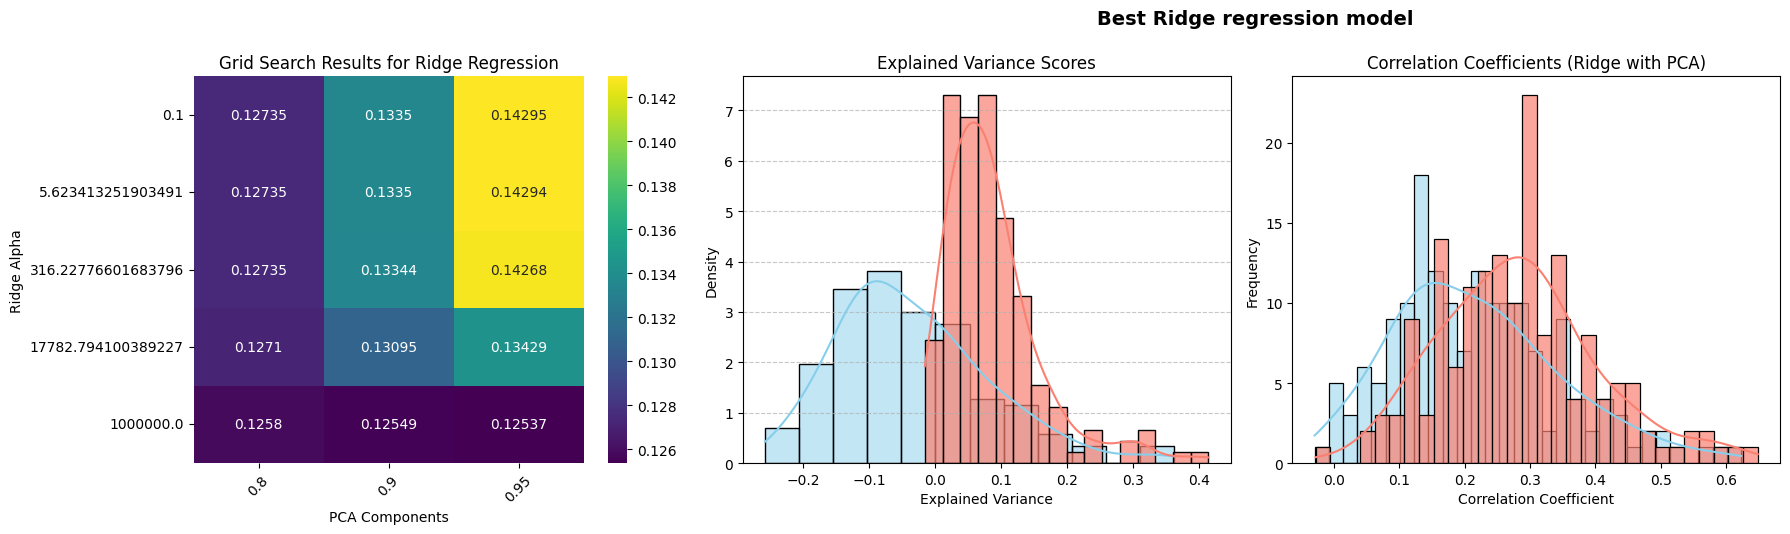

In [31]:
ridge_grid_search_df = pd.DataFrame(ridge_grid_search.cv_results_).pivot(
    index='param_ridge__alpha',
    columns='param_pca__n_components',
    values='mean_test_score'
)

# --- Fit the pipeline with best Ridge params ---
pipeline.set_params(**ridge_grid_search.best_params_)
pipeline.fit(X_train, y_train)

# --- Evaluate the model ---
y_pred_final = pipeline.predict(X_val)
explained_variance_final = explained_variance_score(y_val, y_pred_final, multioutput='raw_values')
correlation_final = np.array([
    np.corrcoef(y_val[:, i], y_pred_final[:, i])[0, 1]
    for i in range(y_val.shape[1])
])
mse_final = mean_squared_error(y_val, y_pred_final)
print("Best Ridge parameters: ", ridge_grid_search.best_params_)
print("Best Ridge MSE: ", mse_final)
print("Mean explained variance: ", explained_variance_final.mean())
print("Mean correlation: ", correlation_final.mean())

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Heatmap of Ridge Grid Search Results
sns.heatmap((-1) * ridge_grid_search_df, annot=True, fmt=".5g", cmap="viridis", ax=axs[0])
axs[0].set_title('Grid Search Results for Ridge Regression')
axs[0].set_ylabel('Ridge Alpha')
axs[0].set_xlabel('PCA Components')
axs[0].tick_params(axis='x', rotation=45)
axs[0].tick_params(axis='y', rotation=0)

# Plot 2: Explained Variance Distribution
sns.histplot(explained_variance, kde=True, stat='density', color='skyblue', ax=axs[1])
sns.histplot(explained_variance_final, kde=True, stat='density', color='salmon', alpha=0.7, ax=axs[1])
axs[1].set_title("Explained Variance Scores", fontsize=12)
axs[1].set_xlabel("Explained Variance")
axs[1].set_ylabel("Density")
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

# Plot 3: Correlation Coefficients
sns.histplot(correlation, bins=30, kde=True, color='skyblue', ax=axs[2])
sns.histplot(correlation_final, bins=30, kde=True, color='salmon', alpha=0.7, ax=axs[2])
axs[2].set_title('Correlation Coefficients (Ridge with PCA)')
axs[2].set_xlabel('Correlation Coefficient')
axs[2].set_ylabel('Frequency')

fig.text(0.7, 1.03, "Best Ridge regression model", ha='center', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

We find that alpha has a minimal impact on the performance of the model on validation set.

## Part 2: Predict the neural activity with the task-driven modeling approach

As you have seen in the class, the underlying hypothesis of task-driven modeling is that training the network to perform a relevant behavioral task makes the network to develop representations that resemble the ones of the biological brain. Let's test this hypothesis by loading a pre-trained ResNet50 model and use the activations of each layer to predict the neural activity. Follow these steps:

- Give as input to the network the stimuli and extract the corresponding activations of the following layers ['conv1','layer1','layer2','layer3','layer4','avgpool']
- Compute the 1000 PCs for each layer activation. (Careful that you don't want to store all activations together at the same time because it won't fit in the memory. Therefore, compute the activations and corresponding PCs for each layer and store only the computed PCs).
- Use the PCs of each layer to predict the neural activity using the linear regression models you developed before.
- Compute the goodness of fit using the correlation and explained variance metrics. Do you predict the neural activity better than before?
- Plot the distribution of explained variance with respect to the layer of the network (order them based on the depth). How does the neural activity changes across the model layers, can you make some statements about it?
- Compare the predictions that you obtained using one layer of the pretrained model and the one obtained using the same layer but from a randomly initialized model. Which network can better predict the neural activity and why?

In [23]:
#### Here your code

import torchvision.models as models
from torchvision.models import ResNet50_Weights
import torch

resnet50 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
resnet50_random = models.resnet50(weights=None)

resnet50.eval() # put in inference mode. e.g. disable dropout and batch normaliation
resnet50_random.eval()

resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
dict(resnet50.named_children())['layer1']

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, ke

In [25]:
hooked_layer_names = ['conv1','layer1','layer2','layer3','layer4','avgpool']
activations = {}

def record_hook(module, input, output:torch.Tensor): # called once per entire batch
    output_flattened = output.view(output.shape[0],-1)
    activations_pca = PCA(n_components=1000).fit_transform(output_flattened)
    activations[module] = activations_pca

def shape_hook(module, input, output:torch.Tensor): 
    output_flattened = output.view(output.shape[0],-1)
    print(f"Output shape: {output_flattened.shape}")

for layer_name in hooked_layer_names:
    layer = dict(resnet50.named_children())[layer_name]
    layer.register_forward_hook(record_hook)
    layer.register_forward_hook(shape_hook)

is the image already normalized to what pre-trained resnet expects? 

In [26]:
torch.from_numpy(stimulus_train)[:10].shape

torch.Size([10, 3, 224, 224])

In [27]:
with torch.no_grad(): # don't compute gradiants for speeding things up
    resnet50(torch.from_numpy(stimulus_train))

KeyboardInterrupt: 

In [ ]:
list(activations.values())[4].flatten()

tensor([0.5076, 0.0000, 0.3477,  ..., 0.3175, 0.0000, 0.0142])